In [3]:
import numpy as np
import cv2 as cv
from cake import cake
from matplotlib import pyplot as plt
from cluster_half_shelfs_alpha import Half_shelf_cluster
from confectionery import Confectionery
from particle_data_structure import ParticleDataStruct

# input parameter

In [4]:
obj=np.load("data/obj_traj_1.npy")
# set frames per second
fps=15
# destination video object segmented
destination_video_segmented = '/Users/Hoang_1/Desktop/Master_Arbeit/software/janus_particle_tracking/Video_Data/object_1.avi'
# destination video clustering
destination_video_clustering='/Users/Hoang_1/Desktop/Master_Arbeit/software/janus_particle_tracking/Video_Data/object_1_clustered.avi'
# destination arrowed clustering 
destination_video_arrowed_clustering = '/Users/Hoang_1/Desktop/Master_Arbeit/software/janus_particle_tracking/Video_Data/object_1_clustered_arrows_only_true.avi'
# destination double arrowed clustering 

# rotation path
V_rot=np.load("data/rotation_trajectory_as_rotvec_1.npy")
stream_string=np.load("data/stream_string.npy")

koppenrath=Confectionery()
r_effective=11

structured_data=ParticleDataStruct(obj,stream_string,koppenrath)
data_flat=structured_data.load_data_flat("data/particle_structured_flat_1.npy")
data_flat_effective=structured_data.get_data_flatten_effective(r_effective,data_flat)


In [5]:
# load object trajectory and their correspondent image paths
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
start_frame=round(obj[0,0])
end_frame=round(obj[-1,0])


koppenrath=Confectionery()
r_effective=11
half_shelf_cluster=Half_shelf_cluster(obj, stream_string, confectionery=koppenrath,cut_radius=r_effective)
half_shelf_cluster.load_data_from_np_array(data_flat_effective)

In [6]:
# set frames per second
fps=15
# set annotation
annotate=True
# duplication of pixels
b_length=10

In [7]:

max_radius=round(np.ceil(np.max(obj[:,-1])))
video_name = destination_video_segmented
height=b_length*(2*(max_radius)+1)
width=height
video = cv.VideoWriter(video_name, 0, fps, (height,width),isColor=True)
# for writing on image
font = cv.FONT_HERSHEY_SIMPLEX
org = (20, 25)
fontScale = 1
color = (255, 0, 0)
thickness = 1
B=np.ones((b_length,b_length))
for current_frame_number in range(start_frame,end_frame+1):
    obj_image_current=cv.imread(stream_string[current_frame_number])
    y_pos=obj[current_frame_number-start_frame,2]
    x_pos=obj[current_frame_number-start_frame,1]
    obj_image_current = cv.circle(obj_image_current, (round(x_pos),round(y_pos)), radius=0, color=(0, 0, 255), thickness=-1)
    object_indeces=np.s_[round(y_pos-max_radius):round(y_pos+max_radius)+1,
                        round(x_pos-max_radius):round(x_pos+max_radius)+1,:]
    obj_image_current=obj_image_current[object_indeces]
    temp_im=np.zeros((obj_image_current.shape[0]*b_length,obj_image_current.shape[1]*b_length,obj_image_current.shape[2]),np.uint8)
    for i in range(3):
        temp_im[:,:,i]=np.kron(obj_image_current[:,:,i],B)
    if annotate==True:
        temp_im=cv.putText(temp_im, '#'+str(current_frame_number).zfill(3), org, font, 
                    fontScale, color, thickness, cv.LINE_AA)
    video.write(temp_im)
cv.destroyAllWindows()
video.release()



# Clustering and tracking next to each other

In [8]:
max_radius=round(np.ceil(np.max(obj[:,-1])))
b_length=10
video_name = destination_video_clustering
height=b_length*(2*(max_radius)+1)
width=2*height
#width=height
video = cv.VideoWriter(video_name, 0, fps, (width,height),isColor=True)
# for writing on image
font = cv.FONT_HERSHEY_SIMPLEX
org = (20, 25)
fontScale = 1
color = (255, 0, 0)
thickness = 1
blue_vector=np.reshape(np.array([255,0,0]),(1,1,3))
green_vector=np.reshape(np.array([0,128,0]),(1,1,3))
B=np.ones((b_length,b_length))
for current_frame_number in range(start_frame,end_frame+1):
    # get object image part
    obj_image_current=cv.imread(stream_string[current_frame_number])
    y_pos=obj[current_frame_number-start_frame,2]
    x_pos=obj[current_frame_number-start_frame,1]
    radius=np.ceil(obj[current_frame_number,3])
    object_indeces=np.s_[round(y_pos-radius):round(y_pos+radius)+1,
                        round(x_pos-radius):round(x_pos+radius)+1,:]
    obj_image_current=obj_image_current[object_indeces]
    obj_image_current_gray=cv.cvtColor(obj_image_current,cv.COLOR_RGB2GRAY)

    # cut border
    image_shape=obj_image_current_gray.shape
    cut_radius=round(r_effective)
    M=koppenrath.sell_cake(r_effective,obj_image_current_gray.shape[0],obj_image_current_gray.shape[0])
    object_pixels=np.copy(obj_image_current_gray)
    object_pixels=np.float32(object_pixels[M==1])
    label=half_shelf_cluster.label(object_pixels.reshape(-1),method="GMM")
    label=label+1
    object_clustered=np.zeros(image_shape,np.uint8)
    object_clustered[M==1]=label.reshape(-1)



    temp_clustered=np.zeros(obj_image_current.shape,np.uint8)
    for l in range(image_shape[0]):
        for k in range(image_shape[1]):
            if object_clustered[l,k]==1:
                temp_clustered[l,k,:]=blue_vector
            elif object_clustered[l,k]==2:
                temp_clustered[l,k,:]=green_vector
    object_clustered=temp_clustered

    #pad arrays until they have suitable shape
    pad_length=round(max_radius-radius)
    temp_1=np.zeros((2*(max_radius)+1,2*(max_radius)+1,3),np.uint8)
    temp_2=np.copy(temp_1)
    for i in range(3):
        temp_1[:,:,i]=np.pad(obj_image_current[:,:,i], pad_width=[(pad_length,pad_length),(pad_length,pad_length)], mode='constant')
        temp_2[:,:,i]=np.pad(object_clustered[:,:,i], pad_width=[(pad_length,pad_length),(pad_length,pad_length)], mode='constant')

    temp_im_1=np.zeros((temp_1.shape[0]*b_length,temp_1.shape[1]*b_length,3),np.uint8)
    temp_im_2=np.copy(temp_im_1)
    for i in range(3):
        temp_im_1[:,:,i]=np.kron(temp_1[:,:,i],B)
        temp_im_2[:,:,i]=np.kron(temp_2[:,:,i],B)
    temp_im=np.zeros((height,width,3),np.uint8)
    temp_im[:,:temp_im_1.shape[0],:]=temp_im_1
    temp_im[:,temp_im_1.shape[0]:,:]=temp_im_2
    if annotate==True:
        temp_im=cv.putText(temp_im, '#'+str(current_frame_number).zfill(3), org, font, 
                    fontScale, color, thickness, cv.LINE_AA)
    video.write(np.uint8(temp_im))
cv.destroyAllWindows()
video.release()


# arrow directions

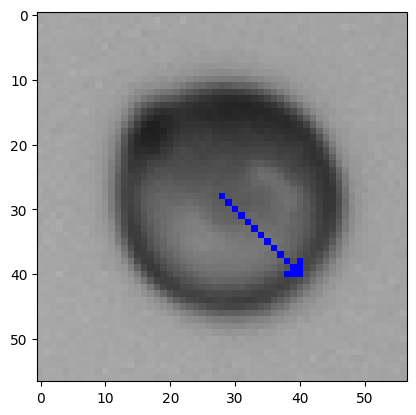

In [9]:
# arrow directions
frame_number=10
x=obj[frame_number-start_frame,1]
y=obj[frame_number-start_frame,2]
r_max=obj[frame_number,3]
a=10
object_indeces=np.s_[-a+round(y-round(r_max)):round(y+round(r_max))+1+a,
                     -a+round(x-round(r_max)):round(x+round(r_max))+1+a,:]
im_obj=cv.imread(stream_string[frame_number],cv.IMREAD_COLOR) 
im_obj=np.array(im_obj)
im_obj=im_obj[object_indeces]


v=1/np.sqrt(2)*np.ones(2)
arrow_length = r_max
width=im_obj.shape[0]
start_point = (width // 2, width // 2)
end_point = (start_point[0] + int(v[0] * arrow_length), start_point[1] + int(v[1] * arrow_length))

im_obj=cv.arrowedLine(im_obj, start_point, end_point, (0,0,255), 1)

plt.figure()
plt.imshow(im_obj)
plt.show()

In [11]:
max_radius=round(np.ceil(np.max(obj[:,-1])))
V_true=obj[1:,1:3]-obj[:-1,1:3]
V_true=V_true[start_frame:end_frame+1,:]
dist_true=np.linalg.norm(V_true,axis=1)
V_true=np.array([v/np.linalg.norm(v) if np.linalg.norm(v)>1e-6 else np.zeros(2) for v in V_true])
#norm_const=max_radius/np.max(dist_true)
norm_const=max_radius/np.mean(dist_true)

V_rot=np.load("/Users/Hoang_1/Desktop/Master_Arbeit/software/janus_particle_tracking/plot_folder/data/obj_0_pos_from_rot.npy")
V_rot=V_rot[1:,:]-V_rot[:-1,:]
V_rot=V_rot[start_frame:end_frame+1,:]
dist_rot=np.linalg.norm(V_rot,axis=1)
V_rot=np.array([v/np.linalg.norm(v) if np.linalg.norm(v)>1e-6 else np.zeros(2) for v in V_rot])

b_length=10
video_name = destination_video_arrowed_clustering
height=b_length*(2*(max_radius)+1)
width=2*height
#width=height
video = cv.VideoWriter(video_name, 0, fps, (width,height),isColor=True)
# for writing on image
font = cv.FONT_HERSHEY_SIMPLEX
org = (20, 25)
fontScale = 1
color = (255, 0, 0)
thickness = 1
blue_vector=np.reshape(np.array([255,0,0]),(1,1,3))
green_vector=np.reshape(np.array([0,128,0]),(1,1,3))
B=np.ones((b_length,b_length))
for current_frame_number in range(start_frame,end_frame):
    # get object image part
    obj_image_current=cv.imread(stream_string[current_frame_number])
    y_pos=obj[current_frame_number-start_frame,2]
    x_pos=obj[current_frame_number-start_frame,1]
    radius=np.ceil(obj[current_frame_number,3])
    object_indeces=np.s_[round(y_pos-radius):round(y_pos+radius)+1,
                        round(x_pos-radius):round(x_pos+radius)+1,:]
    obj_image_current=obj_image_current[object_indeces]
    obj_image_current_gray=cv.cvtColor(obj_image_current,cv.COLOR_RGB2GRAY)

    arrow_length = dist_true[current_frame_number]*norm_const
    if arrow_length>max_radius:
        arrow_length=max_radius
    
    v=V_true[current_frame_number,:]
    start_point = (obj_image_current.shape[0] // 2, obj_image_current.shape[0] // 2)
    end_point = (start_point[0] + int(v[0] * arrow_length), start_point[1] + int(v[1] * arrow_length))
    obj_image_current=cv.arrowedLine(obj_image_current, start_point, end_point, (255,0,0), 1)
    
    arrow_length = dist_rot[current_frame_number]*norm_const
    if arrow_length>max_radius:
        arrow_length=max_radius
    
    v=V_rot[current_frame_number,:]
    start_point = (obj_image_current.shape[0] // 2, obj_image_current.shape[0] // 2)
    end_point = (start_point[0] + int(v[0] * arrow_length), start_point[1] + int(v[1] * arrow_length))
    #obj_image_current=cv.arrowedLine(obj_image_current, start_point, end_point, (0,255,0), 1)

    # cut border
    image_shape=obj_image_current_gray.shape
    cut_radius=round(obj[current_frame_number,-1]*0.6)
    M=koppenrath.sell_cake(r_effective,obj_image_current_gray.shape[0],obj_image_current_gray.shape[0])
    object_pixels=np.copy(obj_image_current_gray)
    object_pixels=np.float32(object_pixels[M==1])
    label=half_shelf_cluster.label(object_pixels.reshape(-1),method="GMM")
    label=label+1
    object_clustered=np.zeros(image_shape,np.uint8)
    object_clustered[M==1]=label.reshape(-1)



    temp_clustered=np.zeros(obj_image_current.shape,np.uint8)
    for l in range(image_shape[0]):
        for k in range(image_shape[1]):
            if object_clustered[l,k]==1:
                temp_clustered[l,k,:]=blue_vector
            elif object_clustered[l,k]==2:
                temp_clustered[l,k,:]=green_vector
    object_clustered=temp_clustered

    #pad arrays until they have suitable shape
    pad_length=round(max_radius-radius)
    temp_1=np.zeros((2*(max_radius)+1,2*(max_radius)+1,3),np.uint8)
    temp_2=np.copy(temp_1)
    for i in range(3):
        temp_1[:,:,i]=np.pad(obj_image_current[:,:,i], pad_width=[(pad_length,pad_length),(pad_length,pad_length)], mode='constant')
        temp_2[:,:,i]=np.pad(object_clustered[:,:,i], pad_width=[(pad_length,pad_length),(pad_length,pad_length)], mode='constant')

    temp_im_1=np.zeros((temp_1.shape[0]*b_length,temp_1.shape[1]*b_length,3),np.uint8)
    temp_im_2=np.copy(temp_im_1)
    for i in range(3):
        temp_im_1[:,:,i]=np.kron(temp_1[:,:,i],B)
        temp_im_2[:,:,i]=np.kron(temp_2[:,:,i],B)
    temp_im=np.zeros((height,width,3),np.uint8)
    temp_im[:,:temp_im_1.shape[0],:]=temp_im_1
    temp_im[:,temp_im_1.shape[0]:,:]=temp_im_2
    if annotate==True:
        temp_im=cv.putText(temp_im, '#'+str(current_frame_number).zfill(3), org, font, 
                    fontScale, color, thickness, cv.LINE_AA)
    video.write(np.uint8(temp_im))
cv.destroyAllWindows()
video.release()
